**Name:** Tacsay, Marie Emmanuelle T.
<br> **Section:** CPE32S8
<br> **Instructor:** Engr. Roman Richard

# **Activity 4.4 Deep Learning in Time Series**

Objective(s):
<br> This activity aims to introduce how to build and train a simple RNN or LSTM for time series forecasting, using Keras.

Intended Learning Outcomes (ILOs):
* Demonstrate how to build and train RNN for time series forecasting
* Demonstrate how to build and train LSTM for time series forecasting

Resources:
* Jupyter Notebook
* Beijing.csv

## **Procedures**

In [77]:
#Load the necessary libraries
%matplotlib inline
import sys
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

import pandas as pd
import keras
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, LSTM

Build a recurrent neural network and train it to forecast a single time series.
* Load and setup the dataset

In [78]:
df_Beijing = pd.read_csv(
    '/content/drive/MyDrive/Assignment 7.1_CPE313/Beijing-1.csv')
df_Beijing = df_Beijing[df_Beijing.year >= 2015]
df_Beijing.head(10)

,No,year,month,day,hour,season,PM_Dongsi,PM_Dongsihuan,PM_Nongzhanguan,PM_US Post,DEWP,HUMI,PRES,TEMP,cbwd,Iws,precipitation,Iprec
43824,43825,2015,1,1,0,4,5.0,32.0,8.0,22.0,-21.0,29.0,1034.0,-6.0,SE,0.89,0.0,0.0
43825,43826,2015,1,1,1,4,4.0,12.0,7.0,9.0,-22.0,23.0,1034.0,-4.0,NW,4.92,0.0,0.0
43826,43827,2015,1,1,2,4,3.0,19.0,7.0,9.0,-21.0,27.0,1034.0,-5.0,NW,8.94,0.0,0.0
43827,43828,2015,1,1,3,4,4.0,9.0,11.0,13.0,-21.0,29.0,1035.0,-6.0,NW,12.96,0.0,0.0
43828,43829,2015,1,1,4,4,3.0,11.0,5.0,10.0,-21.0,27.0,1034.0,-5.0,NW,16.98,0.0,0.0
43829,43830,2015,1,1,5,4,3.0,18.0,3.0,6.0,-22.0,23.0,1034.0,-4.0,NW,24.13,0.0,0.0
43830,43831,2015,1,1,6,4,3.0,20.0,6.0,8.0,-23.0,22.0,1034.0,-5.0,NW,25.92,0.0,0.0
43831,43832,2015,1,1,7,4,3.0,22.0,7.0,17.0,-22.0,26.0,1035.0,-6.0,SE,1.79,0.0,0.0
43832,43833,2015,1,1,8,4,NaN,NaN,NaN,11.0,-22.0,29.0,1035.0,-7.0,cv,0.89,0.0,0.0
43833,43834,2015,1,1,9,4,5.0,37.0,11.0,33.0,-22.0,24.0,1035.0,-5.0,NE,1.79,0.0,0.0


Forecast the 'PM' series, which are measurements of air pollution for several different districts. Note
that there are occasional missing values in these series, which we can fill with simple linear
interpolation. To start, we'll focus on the "PM_Dongsi" series and interpolate the missing values.

In [79]:
df_Beijing['PM_Dongsi'] = df_Beijing['PM_Dongsi'].interpolate()
df_Beijing['PM_Dongsi'].head(10)

43824    5.0
43825    4.0
43826    3.0
43827    4.0
43828    3.0
43829    3.0
43830    3.0
43831    3.0
43832    4.0
43833    5.0
Name: PM_Dongsi, dtype: float64

Create a function to extract and plot the last 𝑛 days of data


In [80]:
def get_n_last_days(df, series_name, n_days):
    """
    Extract last n_days of an hourly time series
    """

    return df[series_name][-(24*n_days):]
def plot_n_last_days(df, series_name, n_days):
    """
    Plot last n_days of an hourly time series
    """

    plt.plot(get_n_last_days(df, series_name, n_days), 'k-')
    plt.title('{0} Air Quality Time Series - {1} days'
              .format(series_name, n_days))
    plt.xlabel('Recorded Hour')
    plt.ylabel('Reading')
    plt.grid(alpha=0.3)

Check last 6 weeks of data look like

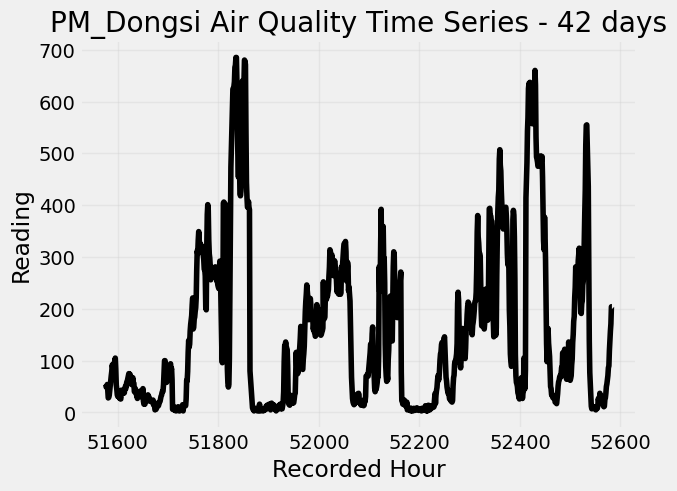

In [81]:
plot_n_last_days(df_Beijing, 'PM_Dongsi', 42)

**Analysis:** The photo above shows the graph distribution of the air quality time series of the place in Beijing called Dongsi

Train a simple RNN to forecast the PM_Dongsi time series

In [82]:
def get_keras_format_series(series):
    """
    Convert a series to a numpy array of shape
    [n_samples, time_steps, features]
    """

    series = np.array(series)
    return series.reshape(series.shape[0], series.shape[1], 1)
def get_train_test_data(df, series_name, series_days, input_hours, test_hours,
                        sample_gap=3):
    """
    Utility processing function that splits an hourly time series into
    train and test with keras-friendly format, according to user-specified
    choice of shape.

    arguments
    ---------
    df (dataframe): dataframe with time series columns
    series_name (string): column name in df
    series_days (int): total days to extract
    input_hours (int): length of sequence input to network
    test_hours (int): length of held-out terminal sequence
    sample_gap (int): step size between start of train sequences; default 5

    returns
    ---------
    tuple: train_X, test_X_init, train_y, test_y
    """

    forecast_series = get_n_last_days(df, series_name, series_days).values
    train = forecast_series[:-test_hours]
    test = forecast_series[-test_hours:]
    train_X, train_y = [], []
    for i in range(0, train.shape[0]-input_hours, sample_gap):
        train_X.append(train[i:i+input_hours])
        train_y.append(train[i+input_hours])
    train_X = get_keras_format_series(train_X)
    train_y = np.array(train_y)

    test_X_init = test[:input_hours]
    test_y = test[input_hours:]

    return train_X, test_X_init, train_y, test_y

With the get_train_test_data utility function in hand, we're all set to extract keras-friendly arrays and
start training simple RNN models. We run this function in the cell below. We use the last 56 days of
the PM_Dongsi series, and will train a model that takes in 12 time steps in order to predict the next
time step. We use the last day of data for visually testing the model.


In [83]:
series_days = 56
input_hours = 12
test_hours = 24

train_X, test_X_init, train_y, test_y = \
    (get_train_test_data(df_Beijing, 'PM_Dongsi', series_days,
                         input_hours, test_hours))

Below we see that by taking multiple time slices, we get 436 training samples of 12 time steps each.

In [84]:
print('Training shape: {}'.format(train_X.shape))

Training shape: (436, 12, 1)


Train a simple RNN model using keras.

In [85]:
def fit_SimpleRNN(train_X, train_y, cell_units, epochs):
    """
    Fit Simple RNN to data train_X, train_y

    arguments
    ---------
    train_X (array): input sequence samples for training
    train_y (list): next step in sequence targets
    cell_units (int): number of hidden units for RNN cells
    epochs (int): number of training epochs
    """

    # initialize model
    model = Sequential()

    # construct an RNN layer with specified number of hidden units
    # per cell and desired sequence input format
    model.add(SimpleRNN(cell_units, input_shape=(train_X.shape[1],1)))

    # add an output layer to make final predictions
    model.add(Dense(1))

    # define the loss function / optimization strategy, and fit
    # the model with the desired number of passes over the data (epochs)
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(train_X, train_y, epochs=epochs, batch_size=64, verbose=0)

    return model

Use this function to fit a very simple baseline model.

In [86]:
model = fit_SimpleRNN(train_X, train_y, cell_units=10, epochs=10)

This prediction method and a utility function for plotting its output against the ground truth are
defined below.

1/1 [==============================] - 0s 30ms/step


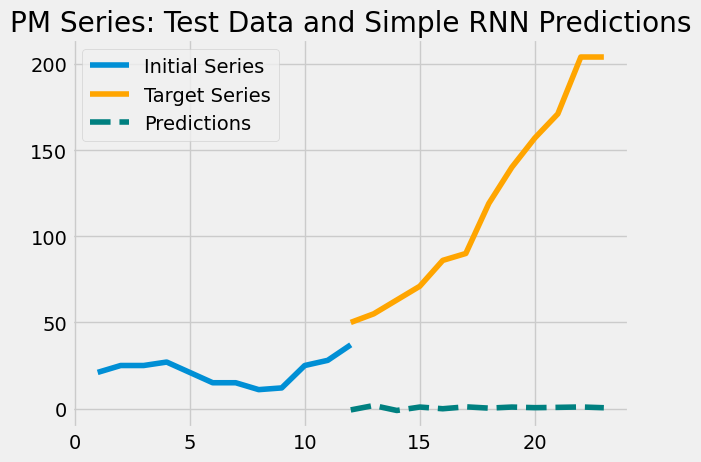

In [87]:
def predict(X_init, n_steps, model):
    """
    Given an input series matching the model's expected format,
    generates model's predictions for next n_steps in the series
    """

    X_init = X_init.copy().reshape(1,-1,1)
    preds = []

    # iteratively take current input sequence, generate next step pred,
    # and shift input sequence forward by a step (to end with latest pred).
    # collect preds as we go.
    for _ in range(n_steps):
        pred = model.predict(X_init)
        preds.append(pred)
        X_init[:,:-1,:] = X_init[:,1:,:]
        X_init[:,-1,:] = pred

    preds = np.array(preds).reshape(-1,1)

    return preds
def predict_and_plot(X_init, y, model, title):
    """
    Given an input series matching the model's expected format,
    generates model's predictions for next n_steps in the series,
    and plots these predictions against the ground truth for those steps

    arguments
    ---------
    X_init (array): initial sequence, must match model's input shape
    y (array): true sequence values to predict, follow X_init
    model (keras.models.Sequential): trained neural network
    title (string): plot title
    """

    y_preds = predict(test_X_init, n_steps=len(y), model=model)

    start_range = range(1, input_hours+1)
    predict_range = range(input_hours, test_hours)

    plt.plot(start_range, test_X_init)
    plt.plot(predict_range, test_y, color='orange')
    plt.plot(predict_range, y_preds, color='teal', linestyle='--')

    plt.title(title)
    plt.legend(['Initial Series','Target Series','Predictions'])
predict_and_plot(test_X_init, test_y, model,
                 'PM Series: Test Data and Simple RNN Predictions')

Retrain the model a few times in order to get results that we're happy with.

1/1 [==============================] - 0s 29ms/step
Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_11 (SimpleRNN)   (None, 30)                960       
                                                                 
 dense_21 (Dense)            (None, 1)                 31        
                                                                 
Total params: 991 (3.87 KB)
Trainable params: 991 (3.87 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


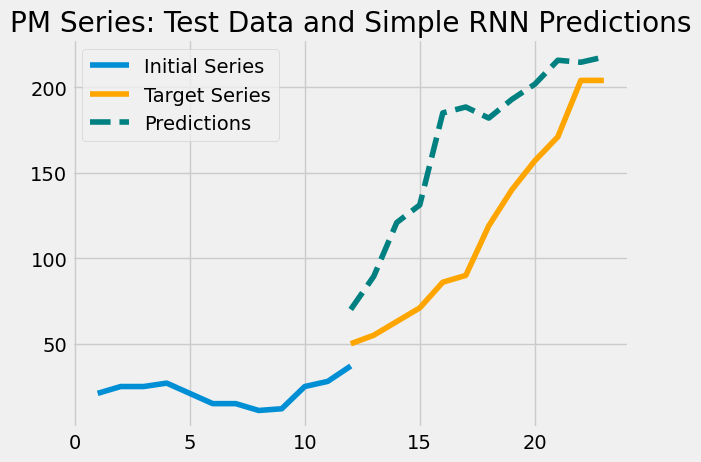

In [88]:
model = fit_SimpleRNN(train_X, train_y, cell_units=30, epochs=1200)
predict_and_plot(test_X_init, test_y, model,
                 'PM Series: Test Data and Simple RNN Predictions')
model.summary()

**Analysis:** The photo above shows the graph of the prediction made by the RNN model. It illustrated the prediction created by the model which is top or between the initial and taget series of data. With this illustration it may be that the predicted values are biased since it doesn't attached to the target series of data.

### **LSTM**

Write a new function for fitting an LSTM with keras

In [104]:
def fit_LSTM(train_X, train_y, cell_units, epochs):
    """
    Fit LSTM to data train_X, train_y

    arguments
    ---------
    train_X (array): input sequence samples for training
    train_y (list): next step in sequence targets
    cell_units (int): number of hidden units for LSTM cells
    epochs (int): number of training epochs
    """

    # initialize model
    model = Sequential()

    # construct a LSTM layer with specified number of hidden units
    # per cell and desired sequence input format
    model.add(LSTM(cell_units, input_shape=(train_X.shape[1],1)))

    # add an output layer to make final predictions
    model.add(Dense(1))

    # define the loss function / optimization strategy, and fit
    # the model with the desired number of passes over the data (epochs)
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(train_X, train_y, epochs=epochs, batch_size=64, verbose=0)

    return model

Train a LSTM to forecast the PM_Nongzhanguan time series

1/1 [==============================] - 0s 47ms/step
Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_12 (LSTM)              (None, 70)                20160     
                                                                 
 dense_26 (Dense)            (None, 1)                 71        
                                                                 
Total params: 20231 (79.03 KB)
Trainable params: 20231 (79.03 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


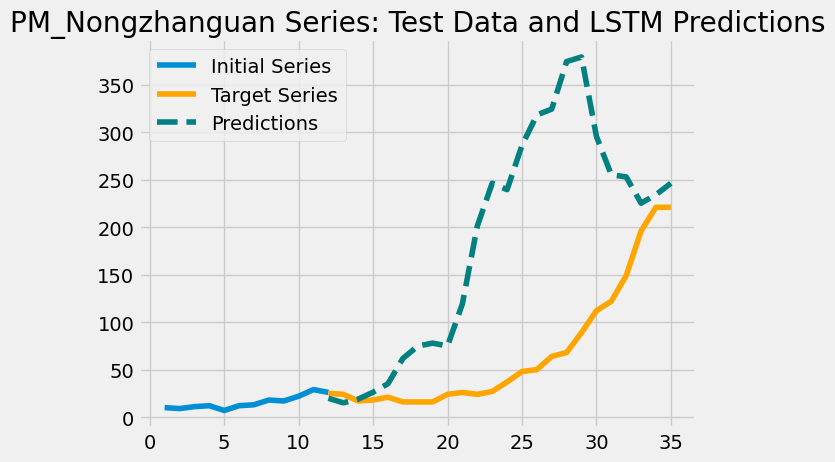

In [105]:
series_days = 50
input_hours = 12
test_hours = 36
train_X, test_X_init, train_y, test_y = \
    (get_train_test_data(df_Beijing, 'PM_Nongzhanguan', series_days,
                         input_hours, test_hours))
model = fit_LSTM(train_X, train_y, cell_units=70, epochs=3000)
predict_and_plot(test_X_init, test_y, model,
                 'PM_Nongzhanguan Series: Test Data and LSTM Predictions')
model.summary()

**Analysis:** The photo above shows the graph of the prediction made by the LSTM model. The data used is from the place in Beijing called Nongzhanguan which describes the air quality time series of the mentioned palce. It illustrated the prediction created by the model which is top or between the initial and taget series of data. With this illustration it may be that the predicted values are biased since it doesn't attached to the target series of data. Also, the parameters are different from the RNN model which can take longer period than the RNN model.

## **Supplementary Activity**

* Train your own model to forecast the "PM_Nongzhanguan" series from the Beijing dataframe.
* Train a LSTM to forecast the PM_Dongsi time series


In [170]:
df_Beijing = pd.read_csv(
    '/content/drive/MyDrive/Assignment 7.1_CPE313/Beijing-1.csv')
df_Beijing = df_Beijing[df_Beijing.year >= 2015]
df_Beijing.head(10)

,No,year,month,day,hour,season,PM_Dongsi,PM_Dongsihuan,PM_Nongzhanguan,PM_US Post,DEWP,HUMI,PRES,TEMP,cbwd,Iws,precipitation,Iprec
43824,43825,2015,1,1,0,4,5.0,32.0,8.0,22.0,-21.0,29.0,1034.0,-6.0,SE,0.89,0.0,0.0
43825,43826,2015,1,1,1,4,4.0,12.0,7.0,9.0,-22.0,23.0,1034.0,-4.0,NW,4.92,0.0,0.0
43826,43827,2015,1,1,2,4,3.0,19.0,7.0,9.0,-21.0,27.0,1034.0,-5.0,NW,8.94,0.0,0.0
43827,43828,2015,1,1,3,4,4.0,9.0,11.0,13.0,-21.0,29.0,1035.0,-6.0,NW,12.96,0.0,0.0
43828,43829,2015,1,1,4,4,3.0,11.0,5.0,10.0,-21.0,27.0,1034.0,-5.0,NW,16.98,0.0,0.0
43829,43830,2015,1,1,5,4,3.0,18.0,3.0,6.0,-22.0,23.0,1034.0,-4.0,NW,24.13,0.0,0.0
43830,43831,2015,1,1,6,4,3.0,20.0,6.0,8.0,-23.0,22.0,1034.0,-5.0,NW,25.92,0.0,0.0
43831,43832,2015,1,1,7,4,3.0,22.0,7.0,17.0,-22.0,26.0,1035.0,-6.0,SE,1.79,0.0,0.0
43832,43833,2015,1,1,8,4,NaN,NaN,NaN,11.0,-22.0,29.0,1035.0,-7.0,cv,0.89,0.0,0.0
43833,43834,2015,1,1,9,4,5.0,37.0,11.0,33.0,-22.0,24.0,1035.0,-5.0,NE,1.79,0.0,0.0


In [171]:
df_Beijing['PM_Nongzhanguan'] = df_Beijing['PM_Nongzhanguan'].interpolate()
df_Beijing['PM_Nongzhanguan'].head(10)

43824     8.0
43825     7.0
43826     7.0
43827    11.0
43828     5.0
43829     3.0
43830     6.0
43831     7.0
43832     9.0
43833    11.0
Name: PM_Nongzhanguan, dtype: float64

In [172]:
def get_n_last_days(df, series_name, n_days):
    """
    Extract last n_days of an hourly time series
    """

    return df[series_name][-(24*n_days):]
def plot_n_last_days(df, series_name, n_days):
    """
    Plot last n_days of an hourly time series
    """

    plt.plot(get_n_last_days(df, series_name, n_days), 'k-')
    plt.title('{0} Air Quality Time Series - {1} days'
              .format(series_name, n_days))
    plt.xlabel('Recorded Hour')
    plt.ylabel('Reading')
    plt.grid(alpha=0.3)

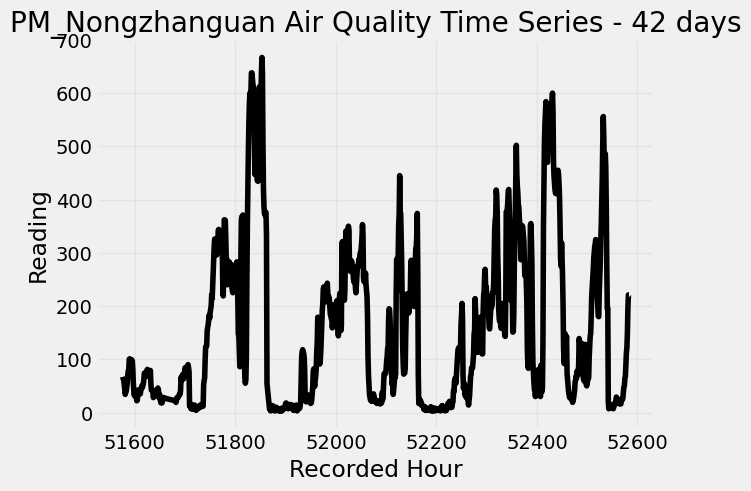

In [173]:
plot_n_last_days(df_Beijing, 'PM_Nongzhanguan', 42)

**Analysis:** The photo above shows the graph distribution of the air quality time series of the place in Beijing called Nongzhanguan

In [174]:
def get_keras_format_series(series):
    """
    Convert a series to a numpy array of shape
    [n_samples, time_steps, features]
    """

    series = np.array(series)
    return series.reshape(series.shape[0], series.shape[1], 1)
def get_train_test_data(df, series_name, series_days, input_hours, test_hours,
                        sample_gap=3):
    """
    Utility processing function that splits an hourly time series into
    train and test with keras-friendly format, according to user-specified
    choice of shape.

    arguments
    ---------
    df (dataframe): dataframe with time series columns
    series_name (string): column name in df
    series_days (int): total days to extract
    input_hours (int): length of sequence input to network
    test_hours (int): length of held-out terminal sequence
    sample_gap (int): step size between start of train sequences; default 5

    returns
    ---------
    tuple: train_X, test_X_init, train_y, test_y
    """

    forecast_series = get_n_last_days(df, series_name, series_days).values
    train = forecast_series[:-test_hours]
    test = forecast_series[-test_hours:]
    train_X, train_y = [], []
    for i in range(0, train.shape[0]-input_hours, sample_gap):
        train_X.append(train[i:i+input_hours])
        train_y.append(train[i+input_hours])
    train_X = get_keras_format_series(train_X)
    train_y = np.array(train_y)

    test_X_init = test[:input_hours]
    test_y = test[input_hours:]

    return train_X, test_X_init, train_y, test_y

In [175]:
series_days = 50
input_hours = 6
test_hours = 12

train_X, test_X_init, train_y, test_y = \
    (get_train_test_data(df_Beijing, 'PM_Nongzhanguan', series_days,
                         input_hours, test_hours))

In [176]:
print('Training shape: {}'.format(train_X.shape))

Training shape: (394, 6, 1)


In [177]:
def fit_SimpleRNN(train_X, train_y, cell_units, epochs):
    """
    Fit Simple RNN to data train_X, train_y

    arguments
    ---------
    train_X (array): input sequence samples for training
    train_y (list): next step in sequence targets
    cell_units (int): number of hidden units for RNN cells
    epochs (int): number of training epochs
    """

    # initialize model
    model = Sequential()

    # construct an RNN layer with specified number of hidden units
    # per cell and desired sequence input format
    model.add(SimpleRNN(cell_units, activation='relu',
                        input_shape=(train_X.shape[1],1)))
    model.add(Dense(1, activation='relu'))

    # add an output layer to make final predictions

    # define the loss function / optimization strategy, and fit
    # the model with the desired number of passes over the data (epochs)
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(train_X, train_y, epochs=epochs, batch_size=64, verbose=0)

    return model

In [178]:
model = fit_SimpleRNN(train_X, train_y, cell_units=20, epochs=10)

1/1 [==============================] - 0s 39ms/step


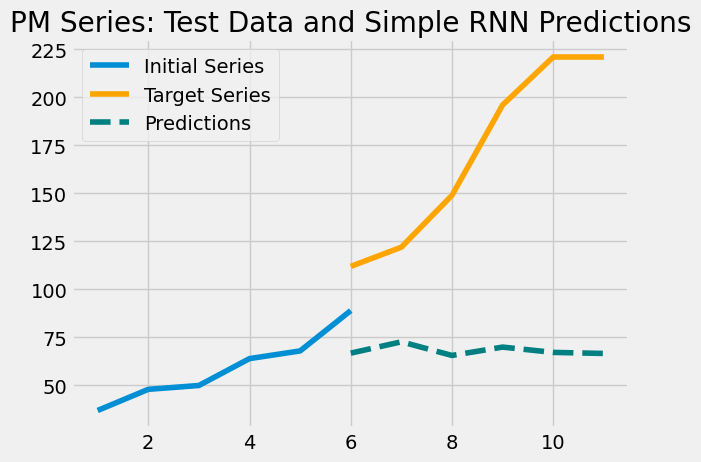

In [179]:
def predict(X_init, n_steps, model):
    """
    Given an input series matching the model's expected format,
    generates model's predictions for next n_steps in the series
    """

    X_init = X_init.copy().reshape(1,-1,1)
    preds = []

    # iteratively take current input sequence, generate next step pred,
    # and shift input sequence forward by a step (to end with latest pred).
    # collect preds as we go.
    for _ in range(n_steps):
        pred = model.predict(X_init)
        preds.append(pred)
        X_init[:,:-1,:] = X_init[:,1:,:]
        X_init[:,-1,:] = pred

    preds = np.array(preds).reshape(-1,1)

    return preds
def predict_and_plot(X_init, y, model, title):
    """
    Given an input series matching the model's expected format,
    generates model's predictions for next n_steps in the series,
    and plots these predictions against the ground truth for those steps

    arguments
    ---------
    X_init (array): initial sequence, must match model's input shape
    y (array): true sequence values to predict, follow X_init
    model (keras.models.Sequential): trained neural network
    title (string): plot title
    """

    y_preds = predict(test_X_init, n_steps=len(y), model=model)

    start_range = range(1, input_hours+1)
    predict_range = range(input_hours, test_hours)

    plt.plot(start_range, test_X_init)
    plt.plot(predict_range, test_y, color='orange')
    plt.plot(predict_range, y_preds, color='teal', linestyle='--')

    plt.title(title)
    plt.legend(['Initial Series','Target Series','Predictions'])
predict_and_plot(test_X_init, test_y, model,
                 'PM Series: Test Data and Simple RNN Predictions')

1/1 [==============================] - 0s 30ms/step
Model: "sequential_46"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_23 (SimpleRNN)   (None, 30)                960       
                                                                 
 dense_46 (Dense)            (None, 1)                 31        
                                                                 
Total params: 991 (3.87 KB)
Trainable params: 991 (3.87 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


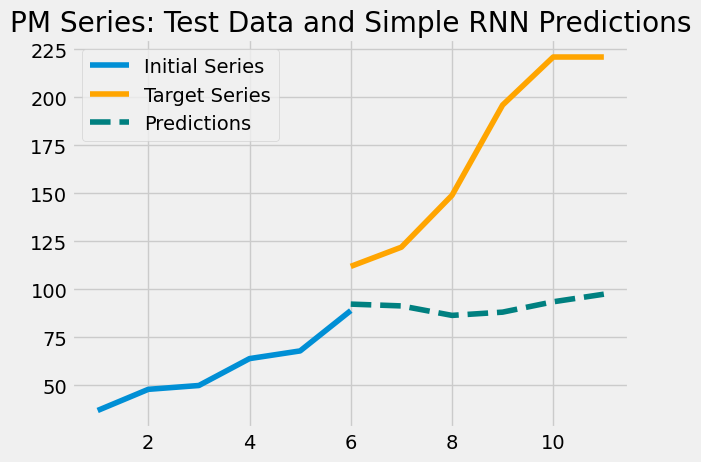

In [180]:
model = fit_SimpleRNN(train_X, train_y, cell_units=30, epochs=1200)
predict_and_plot(test_X_init, test_y, model,
                 'PM Series: Test Data and Simple RNN Predictions')
model.summary()

**Analysis:** The photo above shows the graph of the prediction made by the RNN model. It illustrated the prediction created by the model which is below the target series of data and connects to the initial series data which contraditcs the expected series based from the data it has.

In [181]:
def fit_LSTM(train_X, train_y, cell_units, epochs):
    """
    Fit LSTM to data train_X, train_y

    arguments
    ---------
    train_X (array): input sequence samples for training
    train_y (list): next step in sequence targets
    cell_units (int): number of hidden units for LSTM cells
    epochs (int): number of training epochs
    """

    # initialize model
    model = Sequential()

    # construct a LSTM layer with specified number of hidden units
    # per cell and desired sequence input format
    model.add(LSTM(cell_units, input_shape=(train_X.shape[1],1)))

    # add an output layer to make final predictions
    model.add(Dense(1))

    # define the loss function / optimization strategy, and fit
    # the model with the desired number of passes over the data (epochs)
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(train_X, train_y, epochs=epochs, batch_size=64, verbose=0)

    return model

1/1 [==============================] - 0s 33ms/step
Model: "sequential_47"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_23 (LSTM)              (None, 60)                14880     
                                                                 
 dense_47 (Dense)            (None, 1)                 61        
                                                                 
Total params: 14941 (58.36 KB)
Trainable params: 14941 (58.36 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


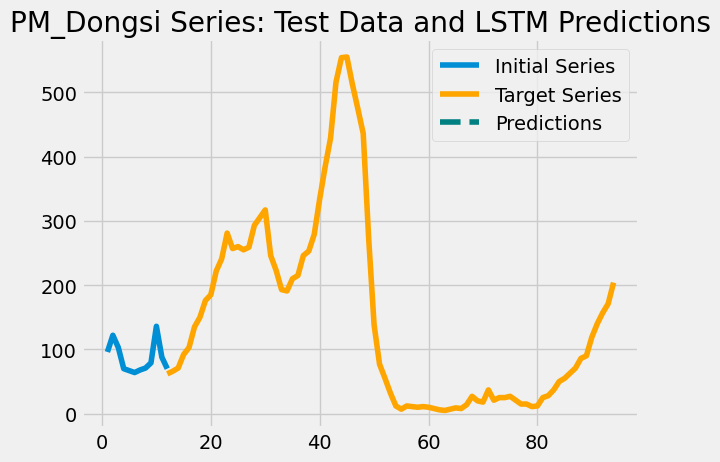

In [182]:
series_days = 50
input_hours = 12
test_hours = 96
train_X, test_X_init, train_y, test_y = \
    (get_train_test_data(df_Beijing, 'PM_Dongsi', series_days,
                         input_hours, test_hours))
model = fit_LSTM(train_X, train_y, cell_units=60, epochs=3000)
predict_and_plot(test_X_init, test_y, model,
                 'PM_Dongsi Series: Test Data and LSTM Predictions')
model.summary()

**Analysis:** The graph above shows the predictions of LSTM model. However, the model doesn't able to predict some values based on the given data provided since there there is no green broken lines. The model should be be modified further and parameters should be changed according to the preferences that the model be able to predict some values.

## **Conclusion**

In this activity, the introduction of the concept of LSTM and RNN happened as well as the demonstration on how to use them. These model are used to predict time series data which is common in the field of business and meteorology which the term prediction is necessary for preparations. Learning and understanding this concepts would be a big help in terms of creating model that will be a solution to a given problem. Overall, this activity shows how to apply the models mentioned in which are evident in the results displayed by these models. The models were able to preduct the values based on the data given.

**Honor Pledge: “I affirm that I shall not give or receive any unauthorized help on this assignment and that all work is my own.”**

Google Colab Link: https://colab.research.google.com/drive/1YOKPKdQsprCPFjAYgCjlrn2xJDpDyE0G?usp=sharing